<a href="https://colab.research.google.com/github/HaukeGS/DLF_Assignment2/blob/main/assignment2_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 Imports and Initializations


In [16]:
# Imports

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter


In [17]:
# label map
CLASS_LABEL_MAP = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.1 Data Loading and Preprocessing


In [19]:
# download training set

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)


In [20]:
# create dataloader

BATCH_SIZE = 16

dataloader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_validation = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [21]:
# for images, labels in dataloader:
#     for image, label in zip(images, labels):
#         fig, axes = plt.subplots(1, 1)
#         axes.imshow(image.squeeze(), cmap='gray')
#         axes.set_title(CLASS_LABEL_MAP.get(label.item()))
#         axes.axis('off')
#         plt.show()
#     break

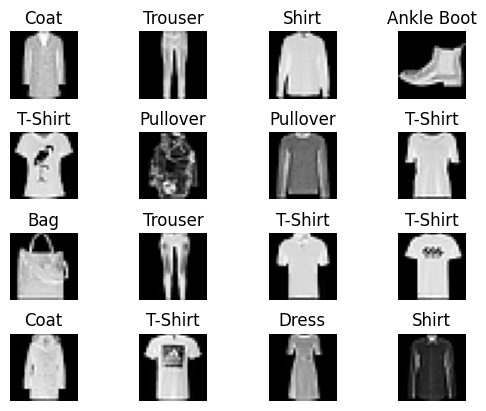

In [47]:
for images, labels in dataloader:
    fig, axes = plt.subplots(4, 4)
    for i in range(4):
        for j in range(4):
            image = images[i * 4 + j]
            label = labels[i * 4 + j]
            axes[i, j].imshow(image.squeeze(), cmap='gray')
            axes[i, j].set_title(CLASS_LABEL_MAP.get(label.item()))
            axes[i, j].axis('off')
    fig.subplots_adjust(hspace=0.5)
    plt.show()
    break

# 1.2 DCGAN Architecture

In [23]:
# Architecture Parameters

# size of latent vector z
Z_LENGTH = 100

# width and height of the images
IMAGE_SIZE = 28

# number of channels
IMAGE_CHANNELS = 1

# size of feature maps
FEATURE_MAPS = 16

# Learning Rate
LEARNING_RATE = 0.0002

### Output Dimensions of ConvTranspode2d

$H_{out}$ = $(H_{in}$ - 1) x stride - 2 x padding + dilation x (kernel_size - 1) + output_padding + 1

In [24]:
dimension = 1

layers = [
    {'in_channels': dimension, 'out_channels': FEATURE_MAPS * 2, 'kernel_size': 6, 'stride': 1, 'padding': 0},
    {'in_channels': FEATURE_MAPS * 2, 'out_channels': FEATURE_MAPS, 'kernel_size': 6, 'stride': 2, 'padding': 1},
    {'in_channels': FEATURE_MAPS, 'out_channels': 1, 'kernel_size': 6, 'stride': 2, 'padding': 2},
]

def calculate_output_dimension(layer):
    return (dimension - 1) * layer.get('stride', 1) - 2 * layer.get('padding', 0) + layer.get('dilation', 1) * (layer.get('kernel_size') - 1) + layer.get('output_padding', 0) + 1

for i, layer in enumerate(layers):
    dimension = calculate_output_dimension(layer)
    print(f"Output dimensions after layer {i}: {layer.get('out_channels')} x {dimension} x {dimension}")

Output dimensions after layer 0: 32 x 6 x 6
Output dimensions after layer 1: 16 x 14 x 14
Output dimensions after layer 2: 1 x 28 x 28


In [31]:
# Generator

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.layers = torch.nn.Sequential(

            # input is Z
            nn.ConvTranspose2d(in_channels=Z_LENGTH, out_channels=FEATURE_MAPS * 2, kernel_size=6, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(FEATURE_MAPS * 2),
            nn.ReLU(True),
            # state size (FEATURE_MAPS * 2) x 6 x 6
            nn.ConvTranspose2d(in_channels=FEATURE_MAPS * 2, out_channels=FEATURE_MAPS, kernel_size=6, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(FEATURE_MAPS),
            nn.ReLU(True),
            # state size FEATURE_MAPS x 14 x 14
            nn.ConvTranspose2d(in_channels=FEATURE_MAPS, out_channels=IMAGE_CHANNELS, kernel_size=6, stride=2, padding=2, bias=False),
            nn.Tanh()
            # state size IMAGE_CHANNELS x 28 x 28
        )

    def forward(self, x):
        return self.layers(x)

In [32]:
# Discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = torch.nn.Sequential(
            # input size is 1 x 28 x 28
            nn.Conv2d(in_channels=IMAGE_CHANNELS, out_channels=FEATURE_MAPS, kernel_size=6, stride=2, padding=0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size FEATURE_MAPS x 12 x 12
            nn.Conv2d(in_channels=FEATURE_MAPS, out_channels=FEATURE_MAPS * 2, kernel_size=6, stride=2, padding=0, bias=False),
            nn.BatchNorm2d(FEATURE_MAPS * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size (FEATURE_MAPS * 2) x 4 x 4
            nn.Conv2d(in_channels=FEATURE_MAPS * 2, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        # print(f"input: {x}")
        # print(f"input size: {x.size()}")
        x = self.layers(x)
        # print(f"output: {x}")
        # print(f"output size: {x.size()}")
        return x

In [33]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# 1.3 Training

In [49]:
# training loop

G_losses = []
D_losses = []

def train(dataloader, discriminator_net, generator_net, optimizer_discriminator, optimizer_generator, num_epochs, fixed_noise):
    for epoch in range(num_epochs):
        dataloader = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")

        generated_images = []
        for i, (images, labels) in enumerate(dataloader):
            # train discriminator on real images
            discriminator_net.zero_grad()
            real_images = images.to(device)
            real_labels = torch.full((BATCH_SIZE,), 1, dtype=torch.float, device=device)
            output = discriminator_net(real_images).view(-1)
            loss_real = criterion(output, real_labels)
            loss_real.backward()

            # train discriminator on fake images
            noise = torch.randn(BATCH_SIZE, Z_LENGTH, 1, 1, device=device)
            fake_images = generator_net(noise)
            fake_labels = torch.full((BATCH_SIZE,), 0, dtype=torch.float, device=device)
            output = discriminator_net(fake_images.detach()).view(-1)
            loss_fake = criterion(output, fake_labels)
            loss_fake.backward()

            # sum up losses and make a step
            loss_discriminator = loss_real + loss_fake
            optimizer_discriminator.step()

            # train generator
            generator_net.zero_grad()
            labels = torch.full((BATCH_SIZE,), 1, dtype=torch.float, device=device)
            output = discriminator_net(fake_images).view(-1)
            loss_generator = criterion(output, labels)
            loss_generator.backward()
            optimizer_generator.step()

            # keep statistics
            D_losses.append(loss_discriminator.item())
            G_losses.append(loss_generator.item())

            # tqdm description
            dataloader.set_postfix({'loss_discriminator': loss_discriminator.item(), 'loss_generator': loss_generator.item()})

            # save generated image on fixed noise to overview progress
            if i % 750 == 0:
                with torch.no_grad():
                    fake_images = generator_net(fixed_noise).detach().cpu()
                generated_images.append(fake_images)

        # print generated images
        fig, axes = plt.subplots(1, len(generated_images))
        for i, image in enumerate(generated_images):
            axes[i].imshow(image[0].squeeze(), cmap='gray')
            axes[i].axis('off')
        plt.show()

In [50]:
# initialize the models

LOAD_FROM_DRIVE = False

generator_net = Generator().to(device)
discriminator_net = Discriminator().to(device)

if LOAD_FROM_DRIVE:
    try:
        generator_net.load_state_dict(torch.load('/content/drive/MyDrive/DCGAN/generator_net.pth'))
        discriminator_net.load_state_dict(torch.load('/content/drive/MyDrive/DCGAN/discriminator_net.pth'))
    except Exception as e:
        print(f"Error loading models from drive: {e}")

generator_net.apply(weights_init)
discriminator_net.apply(weights_init)

# set up loss function and optimizer
criterion = nn.BCELoss()

optimizer_generator = optim.Adam(generator_net.parameters(), lr=LEARNING_RATE)
optimizer_discriminator = optim.Adam(discriminator_net.parameters(), lr=LEARNING_RATE)

Epoch 1/10:   0%|          | 0/3750 [00:00<?, ?it/s]

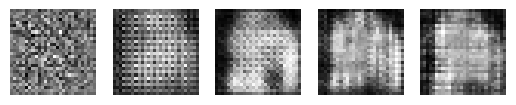

Epoch 2/10:   0%|          | 0/3750 [00:00<?, ?it/s]

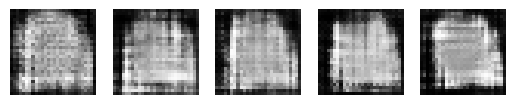

Epoch 3/10:   0%|          | 0/3750 [00:00<?, ?it/s]

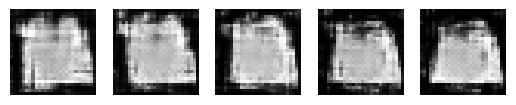

Epoch 4/10:   0%|          | 0/3750 [00:00<?, ?it/s]

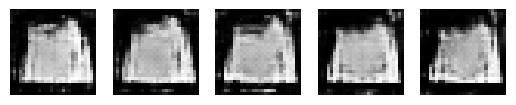

Epoch 5/10:   0%|          | 0/3750 [00:00<?, ?it/s]

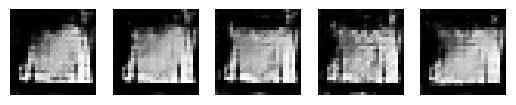

Epoch 6/10:   0%|          | 0/3750 [00:00<?, ?it/s]

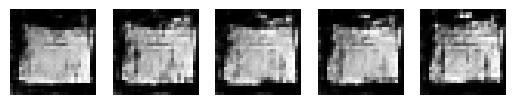

Epoch 7/10:   0%|          | 0/3750 [00:00<?, ?it/s]

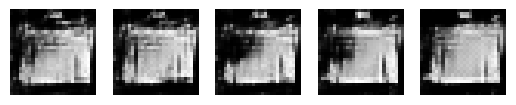

Epoch 8/10:   0%|          | 0/3750 [00:00<?, ?it/s]

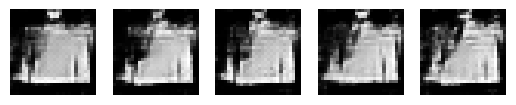

Epoch 9/10:   0%|          | 0/3750 [00:00<?, ?it/s]

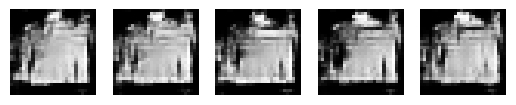

Epoch 10/10:   0%|          | 0/3750 [00:00<?, ?it/s]

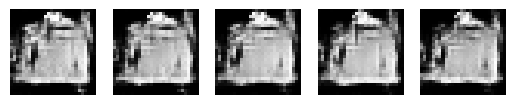

In [51]:
# start trainings loop

train(
    dataloader=dataloader,
    generator_net=generator_net,
    discriminator_net=discriminator_net,
    optimizer_generator=optimizer_generator,
    optimizer_discriminator=optimizer_discriminator,
    num_epochs=10,
    fixed_noise=torch.randn(64, Z_LENGTH, 1, 1, device=device)
)

In [55]:
torch.save(generator_net.state_dict(), '/content/drive/MyDrive/google_colab/DCGAN/generator_net.pth')
torch.save(discriminator_net.state_dict(), '/content/drive/MyDrive/google_colab/DCGAN/discriminator_net.pth')

# 1.4 Evaluation